In [ ]:
import os

zip_file_path = "./drive/MyDrive/COLAB_STUFF/covid19-fake-news-dataset.zip"

destination_directory = "./dataset"

os.makedirs(destination_directory, exist_ok=True)

!unzip "{zip_file_path}" -d "{destination_directory}"

print(f"File '{zip_file_path}' unzipped to '{destination_directory}'")

Archive:  ./drive/MyDrive/COLAB_STUFF/covid19-fake-news-dataset.zip
  inflating: ./dataset/Constraint_Test.csv  
  inflating: ./dataset/Constraint_Test.xlsx  
  inflating: ./dataset/Constraint_Train.csv  
  inflating: ./dataset/Constraint_Train.xlsx  
  inflating: ./dataset/Constraint_Val.csv  
  inflating: ./dataset/english_test_with_labels.csv  
  inflating: ./dataset/test_ernie2.0_results.csv  
File './drive/MyDrive/COLAB_STUFF/covid19-fake-news-dataset.zip' unzipped to './dataset'


In [2]:
from transformers import TFAutoModel, AutoTokenizer
from datasets import load_dataset, Dataset, DatasetDict
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
model = TFAutoModel.from_pretrained("distilbert/distilbert-base-uncased", force_download=True, use_safetensors=False)
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", force_download=True, use_safetensors=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/363M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
Some layers from the model checkpoint at distilbert/distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert/distilbert-base-uncased.
If your task is similar to the task the model

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [4]:
path = "./dataset/"

df_train_path = path + "Constraint_Train.csv"
df_test_path = path + "Constraint_Test.csv"
df_val_path = path + "Constraint_Val.csv"

encoder = LabelEncoder()

df_train = pd.read_csv(df_train_path)
df_train = df_train.drop(columns=['id'])
df_train['label'] = encoder.fit_transform(df_train['label'])

df_test = pd.read_csv(df_test_path)
df_test = df_test.drop(columns=['id'])

df_val = pd.read_csv(df_val_path)
df_val = df_val.drop(columns=['id'])
df_val['label'] = encoder.transform(df_val['label'])

In [5]:
overlap = set(df_train['tweet']).intersection(set(df_test['tweet']))
print(f"Number of overlapping tweets: {len(overlap)}")

Number of overlapping tweets: 0


In [6]:
print(df_train.head())
print(df_test.head())
print(df_val.head())

                                               tweet  label
0  The CDC currently reports 99031 deaths. In gen...      1
1  States reported 1121 deaths a small rise from ...      1
2  Politically Correct Woman (Almost) Uses Pandem...      0
3  #IndiaFightsCorona: We have 1524 #COVID testin...      1
4  Populous states can generate large case counts...      1
                                               tweet
0  Our daily update is published. States reported...
1             Alfalfa is the only cure for COVID-19.
2  President Trump Asked What He Would Do If He W...
3  States reported 630 deaths. We are still seein...
4  This is the sixth time a global health emergen...
                                               tweet  label
0  Chinese converting to Islam after realising th...      0
1  11 out of 13 people (from the Diamond Princess...      0
2  COVID-19 Is Caused By A Bacterium, Not Virus A...      0
3  Mike Pence in RNC speech praises Donald Trump’...      0
4  6/10 Sky's @EdConwa

In [7]:
ds_train = Dataset.from_pandas(df_train)
ds_test = Dataset.from_pandas(df_test)
ds_val = Dataset.from_pandas(df_val)

dataset = DatasetDict({
    'train': ds_train,
    'test': ds_test,
    'val': ds_val
})

dataset

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 6420
    })
    test: Dataset({
        features: ['tweet'],
        num_rows: 2140
    })
    val: Dataset({
        features: ['tweet', 'label'],
        num_rows: 2140
    })
})

In [8]:
MAX_LENGTH = 100

def tokenize(batch):
    return tokenizer(batch["tweet"], padding='max_length', truncation=True, max_length=MAX_LENGTH)

ds_train_encoded = ds_train.map(tokenize, batched=True, batch_size=None)
ds_test_encoded = ds_test.map(tokenize, batched=True, batch_size=None)
ds_val_encoded = ds_val.map(tokenize, batched=True, batch_size=None)

print(ds_train_encoded)
print(ds_test_encoded)
print(ds_val_encoded)

Map:   0%|          | 0/6420 [00:00<?, ? examples/s]

Map:   0%|          | 0/2140 [00:00<?, ? examples/s]

Map:   0%|          | 0/2140 [00:00<?, ? examples/s]

Dataset({
    features: ['tweet', 'label', 'input_ids', 'attention_mask'],
    num_rows: 6420
})
Dataset({
    features: ['tweet', 'input_ids', 'attention_mask'],
    num_rows: 2140
})
Dataset({
    features: ['tweet', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2140
})


In [9]:
BATCH_SIZE = 64

train_dataset = ds_train_encoded.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='label',
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = ds_test_encoded.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataset = ds_val_encoded.to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols='label',
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [10]:
class BERTForClassification(tf.keras.Model):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        self.dropout = tf.keras.layers.Dropout(0.2) ###
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        outputs = self.bert(inputs) ###
        x = outputs.last_hidden_state[:, 0, :] ###
        x = self.dropout(x)
        return self.fc(x)

In [11]:
classifier = BERTForClassification(model)

classifier.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-5), ###
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True ####
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True
)

In [12]:
                                                                        ####
history = classifier.fit(train_dataset, validation_data=valid_dataset, epochs=50, callbacks=[early_stopping, checkpoint])

Epoch 1/50
101/101 [==============================] - ETA: 0s - loss: 0.2982 - accuracy: 0.8646 - precision: 0.8543 - recall: 0.8938

/usr/local/lib/python3.12/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


101/101 [==============================] - 120s 885ms/step - loss: 0.2982 - accuracy: 0.8646 - precision: 0.8543 - recall: 0.8938 - val_loss: 0.1280 - val_accuracy: 0.9519 - val_precision: 0.9512 - val_recall: 0.9571
Epoch 2/50
101/101 [==============================] - ETA: 0s - loss: 0.1126 - accuracy: 0.9583 - precision: 0.9574 - recall: 0.9631

101/101 [==============================] - 87s 862ms/step - loss: 0.1126 - accuracy: 0.9583 - precision: 0.9574 - recall: 0.9631 - val_loss: 0.0939 - val_accuracy: 0.9636 - val_precision: 0.9538 - val_recall: 0.9777
Epoch 3/50
101/101 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9779 - precision: 0.9774 - recall: 0.9804

101/101 [==============================] - 88s 869ms/step - loss: 0.0648 - accuracy: 0.9779 - precision: 0.9774 - recall: 0.9804 - val_loss: 0.0867 - val_accuracy: 0.9636 - val_precision: 0.9736 - val_recall: 0.9563
Epoch 4/50
101/101 [==============================] - 67s 661ms/step - loss: 0.0381 - accuracy: 0.9889 - precision: 0.9878 - recall: 0.9911 - val_loss: 0.0991 - val_accuracy: 0.9696 - val_precision: 0.9543 - val_recall: 0.9893
Epoch 5/50
101/101 [==============================] - 66s 656ms/step - loss: 0.0219 - accuracy: 0.9939 - precision: 0.9940 - recall: 0.9943 - val_loss: 0.0893 - val_accuracy: 0.9701 - val_precision: 0.9673 - val_recall: 0.9759
Epoch 6/50
101/101 [==============================] - 66s 655ms/step - loss: 0.0133 - accuracy: 0.9964 - precision: 0.9967 - recall: 0.9964 - val_loss: 0.0966 - val_accuracy: 0.9710 - val_precision: 0.9649 - val_recall: 0.9804
Epoch 7/50
101/101 [==============================] - 66s 655ms/step - loss: 0.0099 - accuracy: 0.9975 

In [13]:
predictions = classifier.predict(test_dataset)
y_pred = (predictions > 0.5).astype(int)

df_test['predicted_label'] = y_pred

print(df_test.head())

34/34 [==============================] - 9s 199ms/step
                                               tweet  predicted_label
0  Our daily update is published. States reported...                0
1             Alfalfa is the only cure for COVID-19.                1
2  President Trump Asked What He Would Do If He W...                1
3  States reported 630 deaths. We are still seein...                0
4  This is the sixth time a global health emergen...                0


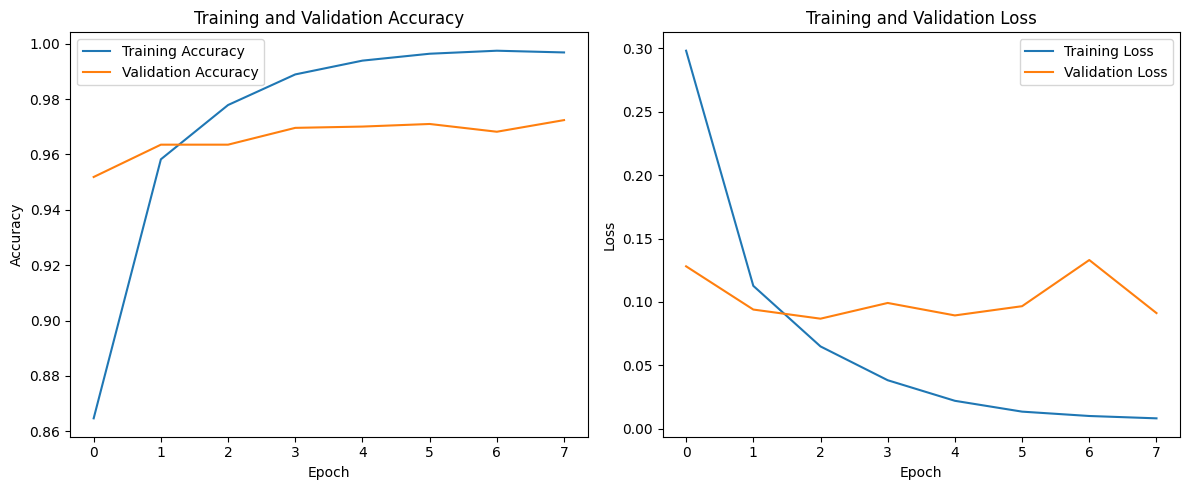

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

plt.tight_layout()
plt.show()

In [15]:
classifier.evaluate(valid_dataset) ###

34/34 [==============================] - 7s 204ms/step - loss: 0.0867 - accuracy: 0.9636 - precision: 0.9736 - recall: 0.9563


[0.08671548962593079, 0.96355140209198, 0.9736363887786865, 0.956250011920929]

In [16]:
classifier.save_weights('model_weights.h5')